In [5]:
#https://github.com/sinanatra/image-tsne/blob/master/notebooks/image_umap.ipynb

import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np
from PIL import Image
from sklearn.feature_extraction import image
from skimage import io
from sklearn.manifold import TSNE
from tqdm import tqdm

In [6]:
data = []
#folder = '../assets/wikidata_crop/'
folder = "C:\\Users\\schwittlick\\Dropbox\\0_MARCELSCHWITTLICK\\2024_WIP\\2024_C94\\c94_website_images\\"

for filename in tqdm((os.listdir(folder))):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (600,600))
        image = image.flatten()
        data.append([image, folder + filename])

100%|██████████| 75/75 [00:00<00:00, 93.99it/s]


In [7]:
features, images  = zip(*data)


In [8]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components = 70)
pca.fit(features)
pca_features = pca.transform(features)

In [9]:
import umap.umap_ as umap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP(
        n_neighbors = 5,
        min_dist = 0.2
)

X = np.array(pca_features)
pipe = Pipeline([('scaling', StandardScaler()), ('umap', reducer)])
embedding = pipe.fit_transform(X)

In [10]:
len(embedding[0]), len(images)

(2, 74)

In [11]:
tx, ty = embedding[:,0], embedding[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

C:\Users\schwittlick\AppData\Local\Temp\ipykernel_36312\2162391940.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)


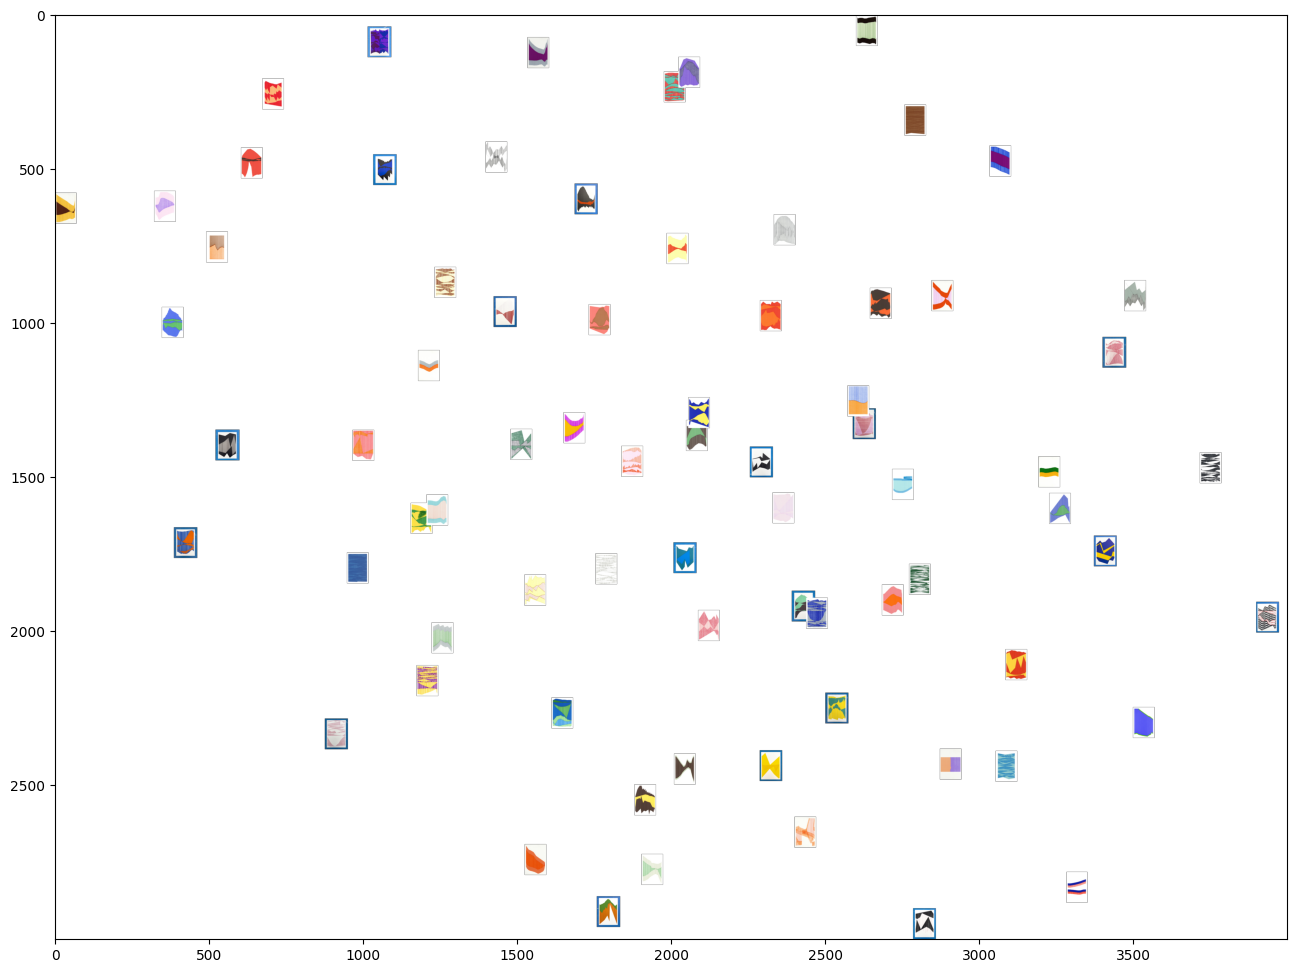

In [12]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [13]:
import rasterfairy
nx = 10
ny = 8

grid_assignment = rasterfairy.transformPointCloud2D(embedding)

no good rectangle found for 74 points, using incomplete square 8 * 10


C:\Users\schwittlick\AppData\Local\Temp\ipykernel_36312\230937251.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)


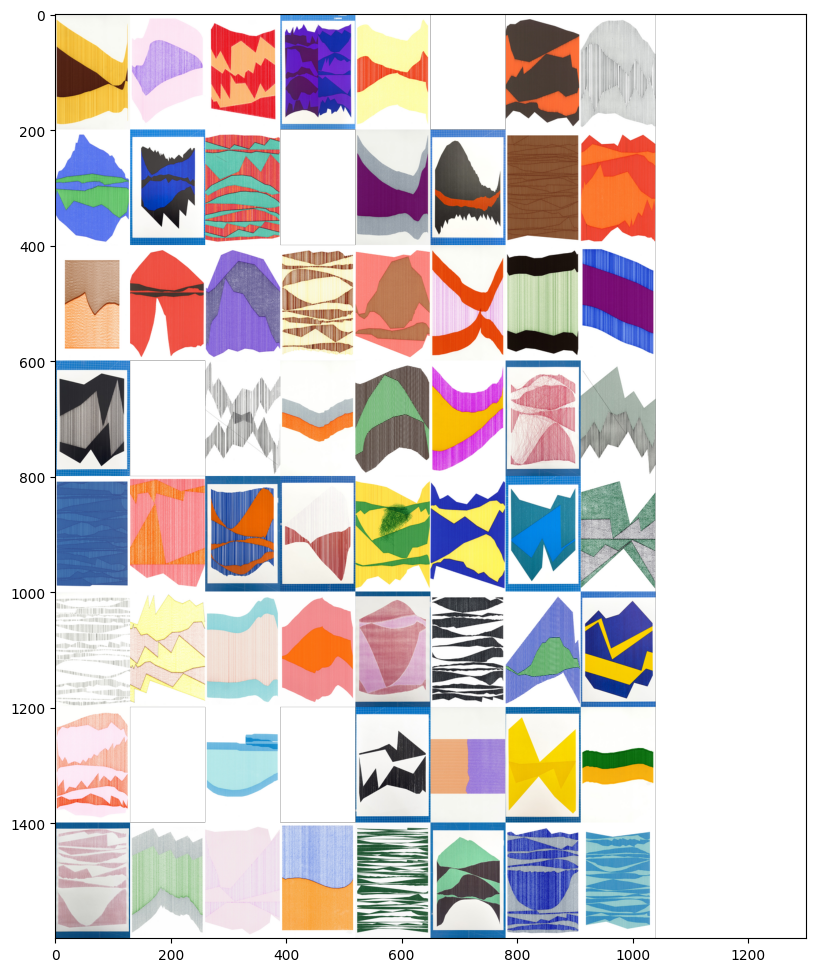

In [14]:
tile_width = 130
tile_height = 200

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGBA', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)